In [1]:
!pip install warnings

zsh:1: command not found: pip


In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [3]:
df = pd.read_excel("/Users/dineshdhakar/Downloads/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [4]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [5]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [7]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [9]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [10]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = furniture['Sales'].resample('MS').mean()

In [12]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

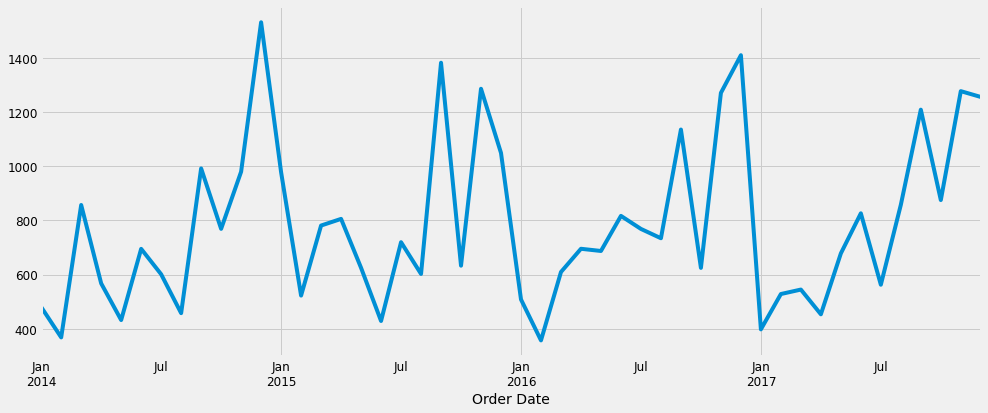

In [13]:
y.plot(figsize=(15, 6))
plt.show()

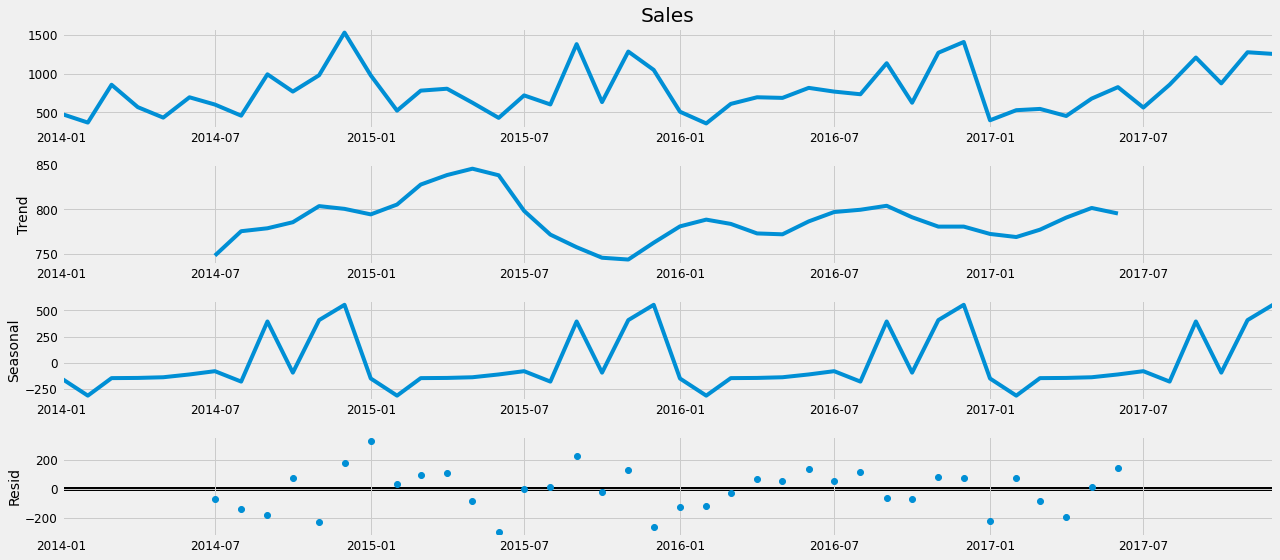

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA
most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1264.3046746655227
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899929659
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1111.6965004450049
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280367373
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.925227075812
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2965.7144602691324
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091437
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673027


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.54010438076796


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2513.1378388170206
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876927759
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576531115
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1033.8343998014668
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.9671228171476
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1559.3370728686368
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200215036
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176709446


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2561.0547535356304
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548483858
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806231716835
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977439806
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2500.938092188855
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75743684170516
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766215065995
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:950.8440594119452
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675165196
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935393


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1398.3201286013202
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.46646750656424
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.5842692186084
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442579545
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2650.5343540310373
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3637985658407
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.3422194967592
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.57633240704666
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:50745294.162024364
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:304.3753786393155
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188294092
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:917.671084558695
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.213061161442
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.34036585859525
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2489565895.5233426
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013121525
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.3264992592116
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019776532
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2562.760715612478
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687397475
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006930426
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.52503546585564
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3034.2168606799437
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439852912
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661015012935


In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


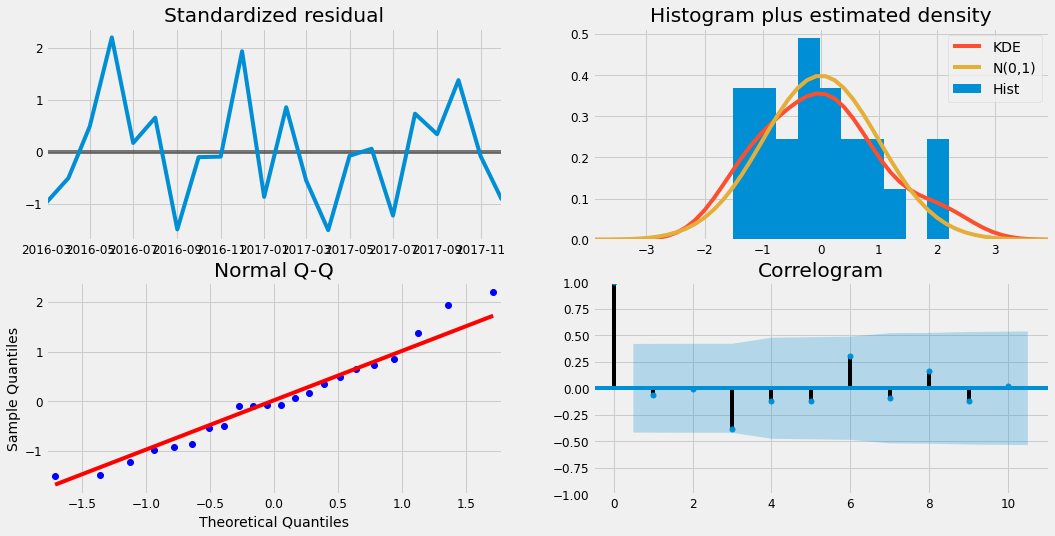

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

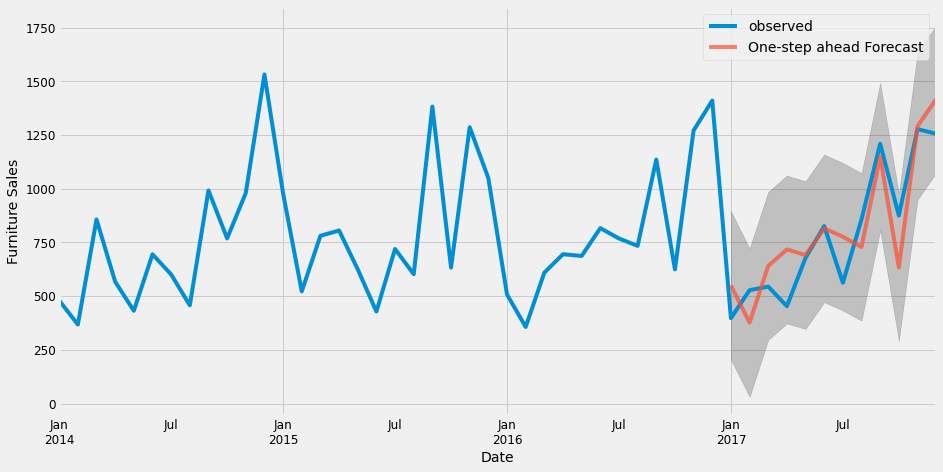

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.5


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

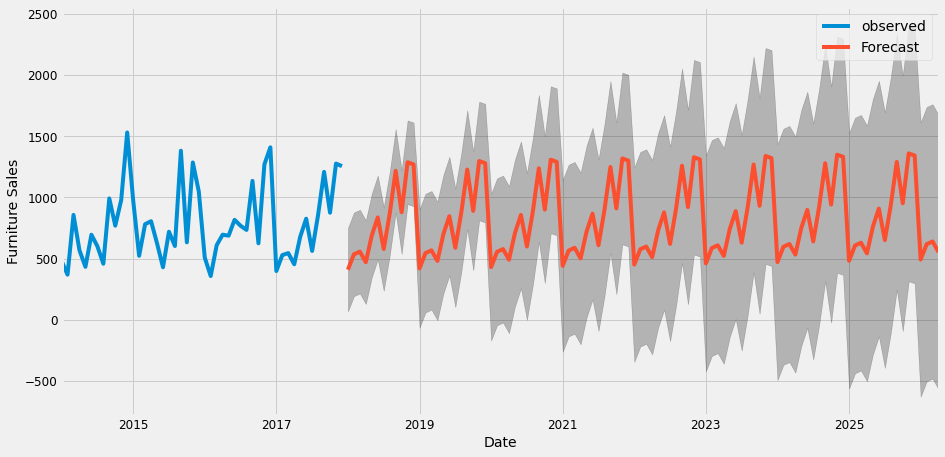

In [31]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.